# Моделирование оттока клиентов

### Что такое отток?

"Интуитивно" понятие оттока понятно - был пользователь, который пользовался нашим сервисом, а потом вдруг перестал это делать. Примеры: перешел в другой банк, в другую телекоммуникационную компанию, стал пользоваться другим сервисом и т.д (в зависимости от того, какая у нас сфера)
 
Можно интерпретировать как **Отток = потерянные пользователи / общее число пользователей**

**Задача оттока** - это часть процесса по выстраиванию взаимоотношений с клиентами, а не просто задача в вакууме
- выстраивание взаимоотношений с пользователем
- успешность кампании зависит от того как устроена работа с пользователями

Таким образом, чем лучше у выстроен процесс работы с пользователями, тем успешнее бизнес в целом

### Для чего прогнозировать отток?

- Чем больше у нас пользователей, тем выше прибыль (особенно, если большая доля выручки - это рекламная монетизация)
- Больше пользователей = привлечение новых + удержание существующих (уменьшение оттока уже существующих)
- У привлечения новых и удержания "старых" разная экономическая эффективность

Любое взаимодействие с клиентами стоит денег, поэтому существует вопрос - **"Что лучше с точки зрения конверсии - привлечение новых клиентов или удержание старых?"**
Ответ на данный вопрос зависит от сферы оказываемых услуг и возможности расширения деятельности

Когда мы определились с самим понятием **оттока** для конкретного сервиса, можно описать примерный план действий:

1. Определить сегмент, кого удерживать
 - Churn
 - Uplift
2. Определить, что предлагать
3. Сделать предложение
4. Дождаться реакции
5. Оценить результаты

# Churn task

Решение задачи **банковского оттока** клиентов на уже очищенных данных + имеется разметка

Данные взять с платформы Kaggle - https://www.kaggle.com/adammaus/predicting-churn-for-bank-customers

In [1]:
import pandas as pd
import numpy as np
import itertools
import seaborn as sns
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix
import matplotlib
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

%matplotlib inline

In [2]:
df = pd.read_csv("churn_data.csv")
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [4]:
df.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


Посмотрим на балансировку

In [5]:
df['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

Посмотрим на распределение количественных данных в разрезе факта оттока

In [6]:
def plot_by_target(data,target):
    sns.set(rc={"figure.figsize": (10, 8)})
    features = data.drop('Exited', axis = 1).select_dtypes(['int64','float64']).columns.to_list()
    for feature in features:
        sns.kdeplot(data.loc[data['Exited']==1, feature])
        sns.kdeplot(data.loc[data['Exited']==0, feature])
        plt.xlabel(feature)
        plt.ylabel('Distribution density')
        plt.title(f'Distribution {feature} in context of target variable')
        plt.show()

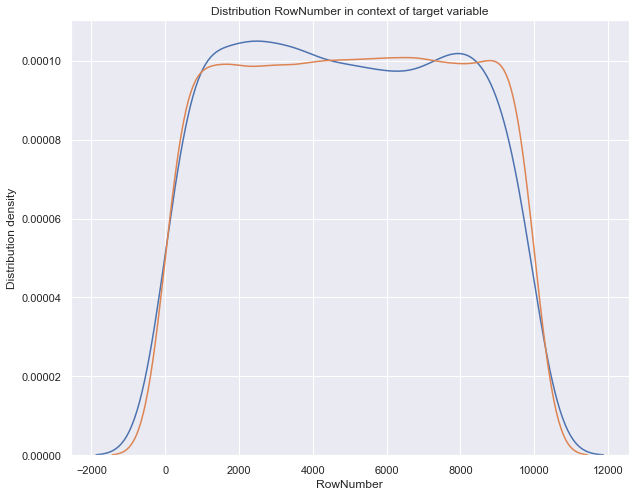

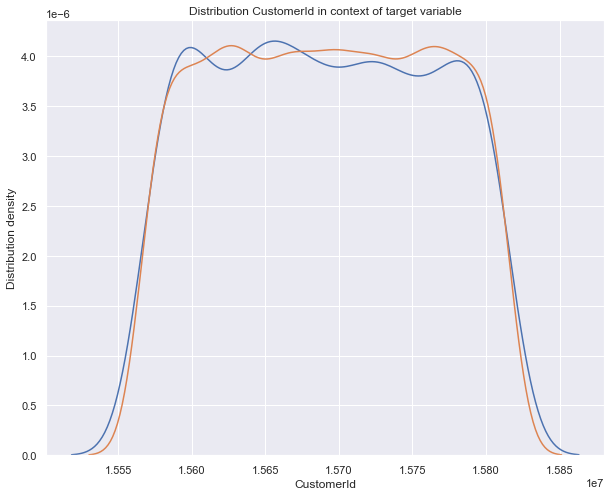

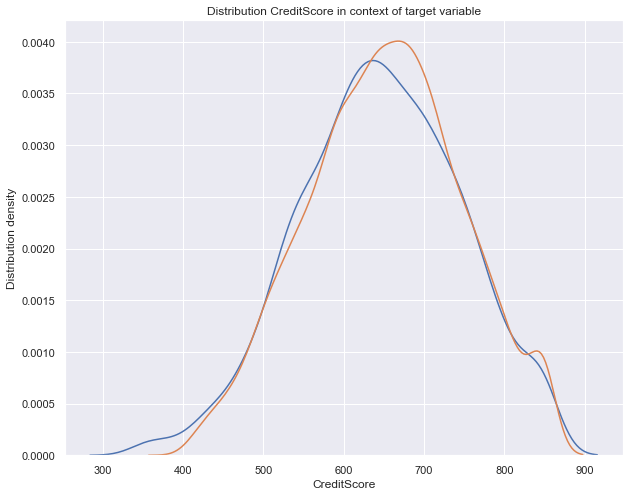

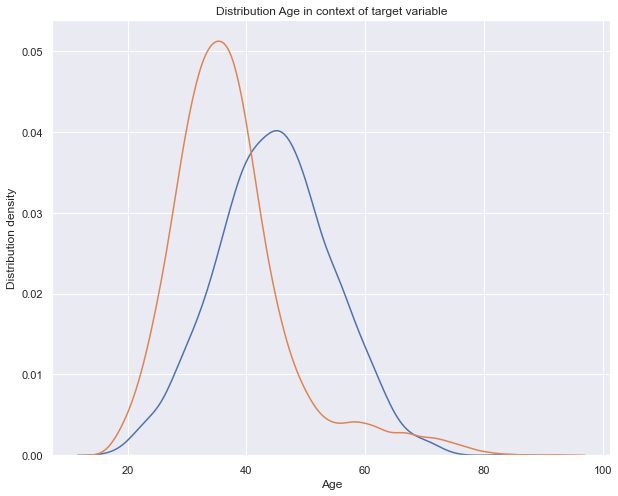

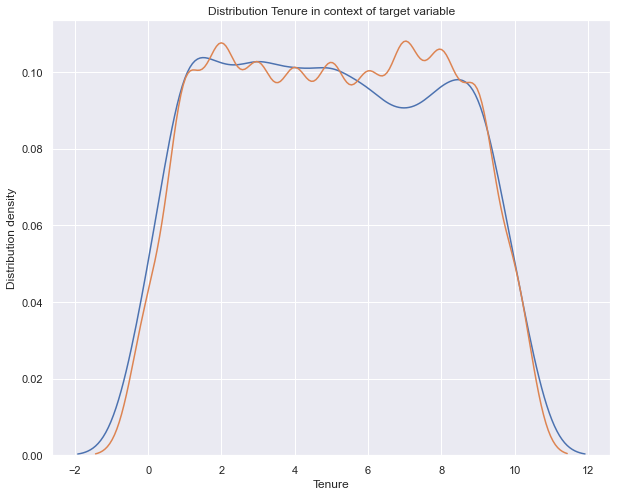

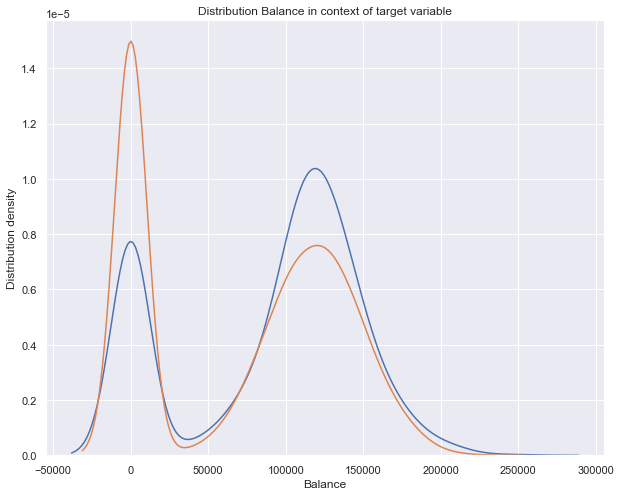

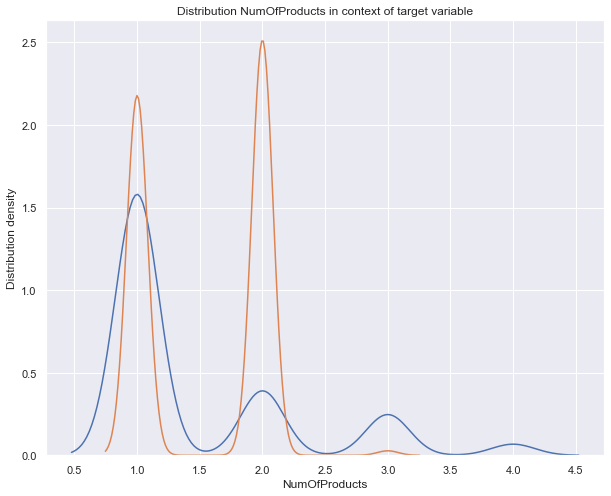

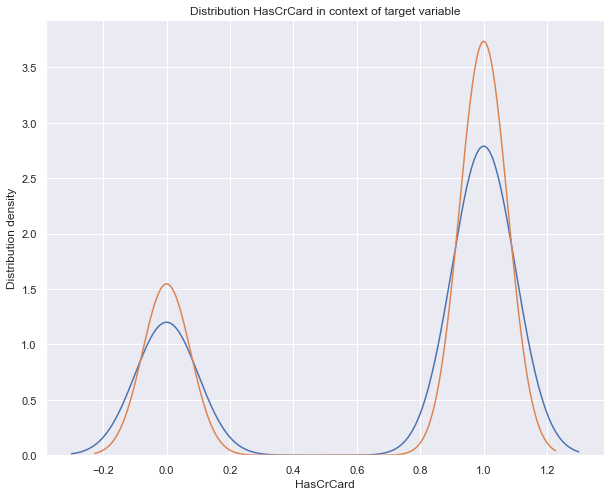

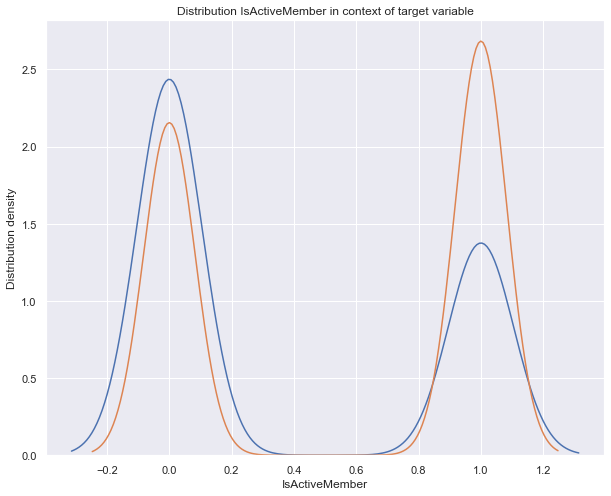

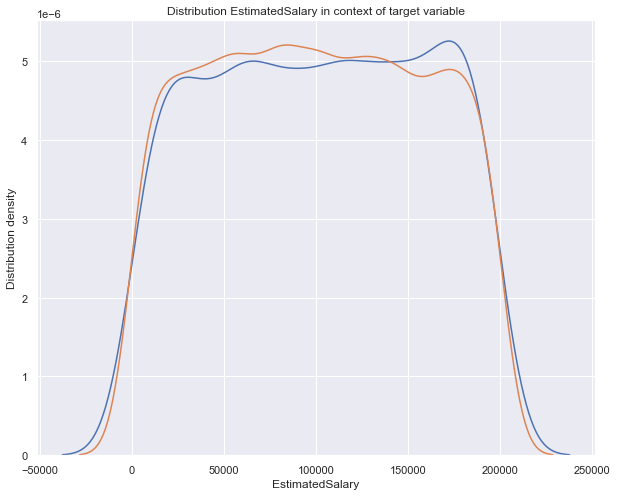

In [7]:
plot_by_target(df,'Exited')

Нельзя сказать, что наблюдается существенная разница в распределении всех выборок, однако в большинстве случаев мы наблюдаем различия. Конечно можно и нужно исследовать различие в соответствии с тестами(в зависимости от "нормальности" распределения - параметрические / непараметрические), но в этой задаче ограничимся визуальной оценкой и грубо построим модель без преобразования признаков.

**Сразу разделим данные на train and test**

In [8]:
X_train, X_test, y_train, y_test = train_test_split(df, df['Exited'], random_state=0)

**Напишем классы обработки для пайплайна**

- Категориальные признаки закодируем с помощью OneHotEncoding
- Вещественные оставим пока как есть

In [9]:
categorical_columns = ['Geography', 'Gender', 'Tenure', 'HasCrCard', 'IsActiveMember']
continuous_columns = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']

In [10]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

**Создадим пайплайн для каждого признака и объединим все пайплайны в FutureUnion**

In [11]:
final_transformers = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    final_transformers.append((cat_col, cat_transformer))
    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    final_transformers.append((cont_col, cont_transformer))
    
    
feats = FeatureUnion(final_transformers)

feature_processing = Pipeline([('feats', feats)])

**Создадим пайплайн и обучим c несколькими моделями**

In [12]:
%%time

pipeline_RFC = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(random_state=42))
])

pipeline_RFC.fit(X_train, y_train)

pipeline_CBC = Pipeline([
    ('features',feats),
    ('classifier', CatBoostClassifier(silent=True, loss_function='Logloss'))
])

pipeline_CBC.fit(X_train, y_train)

pipeline_LR = Pipeline([
    ('features',feats),
    ('classifier', LogisticRegression())
])

pipeline_LR.fit(X_train, y_train)

Wall time: 8.39 s


Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

#### Перейдем от вероятностей к меткам классов. Для этого нужно подобрать порог, после которого мы считаем, что объект можно отнести к классу 1 (если вероятность больше порога - размечаем объект как класс 1, если нет - класс 0)

Напишем функцию для получения метрик каждой модели

In [13]:
def get_score(pipeline):
    
    preds = pipeline.predict_proba(X_test)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y_test, preds)

    fscore = (2 * precision * recall) / (precision + recall)
    roc_auc = roc_auc_score(y_true=y_test, y_score=preds)
    ix = np.argmax(fscore)

    return [round(i, 3) for i in
            [thresholds[ix], fscore[ix], precision[ix], recall[ix], roc_auc]]

Получим метрики от отобразим их в формате DataFrame, отранжированном по ROC-AUC

In [14]:
result = pd.DataFrame([get_score(pipeline_RFC),
                        get_score(pipeline_CBC),
                        get_score(pipeline_LR)], 
        columns=['Best_Threshold', 'F-Score', 'Precision', 'Recall', 'ROC-AUC'])

result['models'] = ['RandomForestClassifier', 'CatBoostClassifier', 'LogisticRegression']
result = result.set_index('models')
result.sort_values(by='ROC-AUC', axis=0, ascending=False)

,Best_Threshold,F-Score,Precision,Recall,ROC-AUC
models,,,,,
CatBoostClassifier,0.371,0.641,0.645,0.637,0.875
RandomForestClassifier,0.380,0.641,0.654,0.629,0.864
LogisticRegression,0.290,0.510,0.462,0.568,0.772


CatBoostClassifier показал себя лучше всех, с другой стороны CatBoost - самая сложная модель из представленных

#### Получим предикты от CatBoost и построим матрицу ошибок

In [15]:
preds = pipeline_CBC.predict_proba(X_test)[:, 1]

In [16]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1813  178]
 [ 186  323]]


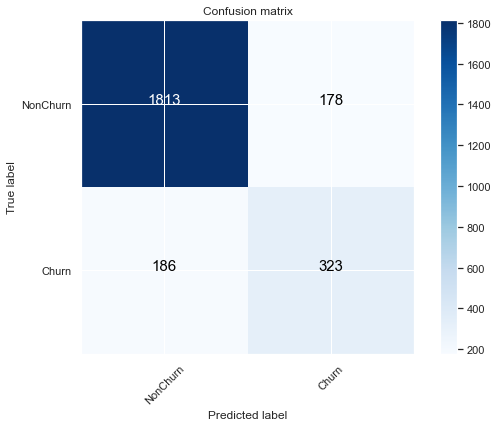

In [17]:
font = {'size' : 15}

plt.rc('font', **font)

precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
ix = np.argmax(fscore)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(8, 6))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.show()

Довольно много ошибаемся по FP и FN, что не есть хорошо:
- Затратим лишние деньги на попытку удержангия клиентов из FP, хотя они не собираются оттекать
- Точно упустим клиентов из FN, которые составляют довольно приличный объем

Не самый выдающийся результат, но я пересчитаю возможную прибыль от данной модели исходя из того, что на удержание клиента тратим **1\$**, а средняя прибыль с каждого TruePositive клиента - **2\$**

In [18]:
costs = sum(cnf_matrix[:, 1]) * 1  # Траты
income = cnf_matrix[1, 1] * 2  # Возможный доход
print(f'Возможная прибыть с удержания = {income - costs}$')

Возможная прибыть с удержания = 145$


Исходя из начальных цифр и ошибок модели, денежная конверсия выглядит не такой уж и плохой

### Попробуем адаптировать CatBoostClassifier с помощью RandomizedSearchCV

In [19]:
from sklearn.model_selection import RandomizedSearchCV

grid = {'classifier__learning_rate': [0.03, 0.1],
        'classifier__depth': [4, 6, 10],
        'classifier__l2_leaf_reg': [1, 3, 5, 7, 9]}

In [20]:
RS = RandomizedSearchCV(estimator = pipeline_CBC,
                 param_distributions=grid,
                 scoring = 'roc_auc',
                 n_jobs=-1,
                 cv = 4,
                 refit=False)

search = RS.fit(X_train, y_train)
search.best_params_

{'classifier__learning_rate': 0.03,
 'classifier__l2_leaf_reg': 5,
 'classifier__depth': 4}

Обучим модель с полученными параметрами и посмотрим на матрицу ошибок

In [21]:
pipeline_CBC = Pipeline([
    ('features',feats),
    ('classifier', CatBoostClassifier(silent=True, learning_rate=0.03, depth=4, l2_leaf_reg=5,loss_function='Logloss'))
])

pipeline_CBC.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

Confusion matrix, without normalization
[[1832  159]
 [ 193  316]]


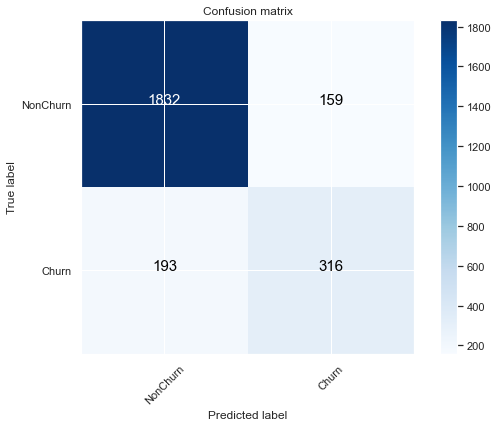

In [22]:
font = {'size' : 15}

plt.rc('font', **font)

preds = pipeline_CBC.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
ix = np.argmax(fscore)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(8, 6))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [24]:
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.386158, F-Score=0.644, Precision=0.666, Recall=0.623


In [25]:
costs = sum(cnf_matrix[:, 1]) * 1  # Траты
income = cnf_matrix[1, 1] * 2  # Возможный доход
print(f'Возможная прибыть с удержания = {income - costs}$')

Возможная прибыть с удержания = 157$


Подбор параметров позволил увеличить условную конверсию

**Что было сделано:**
- Был произведен разбор задачи классификации(не временной ряд) оттока
- Созданы пайплайны обработки и обучения для 3х моделей разного класса, среди них выбрана лучшая
- Проанализирована матрица ошибок и подсчитана возможная прибыль от взаимодействия
- При помощи RandomizedSearchCV были найдены лучшие параметры модели в условиях кросс-валидации
- Пронаблюдали улучшения классификации. Проанализирована новая матрица ошибок и подсчитана возможна прибыль